In [2]:
import numpy as np
import cupy as cp 

from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
kernel = ''' 
# define D2Q9 9
# define D3Q19 19
# define D3Q27 27
# define w_eps_3d19q 3
# define w_eps_j_3d19q 5.5
# define w_xx_3d19q 0.5

# define NUM_THREADS_2D 16
# define NUM_THREADS_3D 6
# define FLUID 0
# define SOLID 1
# define INLET 10
# define OUTLET 30

# define isFalse 0
# define isTrue 1

# define GET_X_2D const long long x = threadIdx.x + blockDim.x * blockIdx.x;
# define GET_Y_2D const long long y = threadIdx.y + blockDim.y * blockIdx.y;
# define GET_IJ const long long ij = ny * x + y;
# define GET_TX_2D const int tx = threadIdx.x;
# define GET_TY_2D const int ty = threadIdx.y;

# define GET_X_3D const long long x = threadIdx.x + blockDim.x * blockIdx.x;
# define GET_Y_3D const long long y = threadIdx.y + blockDim.y * blockIdx.y;
# define GET_Z_3D const long long z = threadIdx.z + blockDim.z * blockIdx.z;
# define GET_IJK const long long ijk = ny * nz * x + nz * y + z;
# define GET_TX_3D const int tx = threadIdx.x;
# define GET_TY_3D const int ty = threadIdx.y;
# define GET_TZ_3D const int tz = threadIdx.z;


__device__ int check_if_out_of_domain_2d(long long nx, long long ny, long long x_new,long long y_new){
int is_out_of_domain = isFalse;
if ((x_new < 0) || (y_new < 0)){
    is_out_of_domain = isTrue;
}

if ((x_new >= nx) || (y_new >= ny)){
    is_out_of_domain = isTrue;
}
return is_out_of_domain;

}

__device__ int check_if_out_of_domain_3d(long long nx, long long ny, long long nz, long long x_new,long long y_new, long long z_new){
int is_out_of_domain = isFalse;
if ((x_new < 0) || (y_new < 0) || (z_new < 0)){
    is_out_of_domain = isTrue;
}

if ((x_new >= nx) || (y_new >= ny) || (z_new >= nz)){
    is_out_of_domain = isTrue;
}
return is_out_of_domain;

}

__device__ float d_m_equilibrium_2d(int c, float rho, float ux, float uy){
float meq = 0;
switch(c){
    case 0:
        meq = rho;
        break;
    case 1:
        meq = -2 * rho + 3 * rho * (ux * ux + uy * uy);
        break;
    case 2:
        meq = rho - 3 * rho * (ux * ux + uy * uy);
        break;
    case 3:
        meq = rho * ux;
        break;
    case 4:
        meq = - rho * ux;
        break;
    case 5:
        meq = rho * uy;
        break;
    case 6:
        meq = - rho * uy;
        break;
    case 7:
        meq = rho * (ux * ux - uy * uy);
        break;
    case 8:
        meq = rho * ux * uy;
        break;
    default:
        meq = 0;
}
return meq;
}

__device__ float d_m_equilibrium_3d19q(int c, float rho, float ux, float uy, float uz){
float meq = 0;
switch(c){
    case 0:
        meq = rho;
        break;
    case 1:
        meq = -11 * rho + 19 * (ux * ux + uy * uy + uz * uz);
        break;
    case 2:
        meq = w_eps_3d19q * rho - w_eps_j_3d19q * rho * (ux * ux + uy * uy + uz * uz);
        break;
    case 3:
        meq = rho * ux;
        break;
    case 4:
        meq = -2 * rho * ux / 3;
        break;
    case 5:
        meq = rho * uy;
        break;
    case 6:
        meq = -2 * rho * uy / 3;
        break;
    case 7:
        meq = rho * uz;
        break;
    case 8:
        meq = -2 * rho * uz / 3;
        break;
    case 9:
        meq = 2 * rho * ux * ux - rho * (uy * uy + uz * uz);
        break;
    case 10:
        meq = w_xx_3d19q * (2 * rho * ux * ux - rho * (uy * uy + uz * uz));
        break;
    case 11:
        meq = rho * (uy * uy - uz * uz);
        break;
    case 12:
        meq = w_xx_3d19q * rho * (uy * uy - uz * uz);
        break;
    case 13:
        meq = rho * ux * uy;
        break;
    case 14:
        meq = rho * uy * uz;
        break;
    case 15:
        meq = rho * ux * uz;
        break;
    case 16:
        meq = 0;
        break;
    case 17:
        meq = 0;
        break;
    case 18:
        meq = 0;
        break;
    default:
        meq = 0;
}
return meq;
}

__device__ float d_fcm_equilibrium_3d27q(int c, float rho_f, float *cm){
// calc equilibrium of central moment
float cm_eq = 0;
switch(c){
    case 0:
        cm_eq = rho_f;
        break;
    case 1:
        cm_eq = 0;
        break;
    case 2:
        cm_eq = 0;
        break;
    case 3:
        cm_eq = 0;
        break;
    case 4:
        cm_eq = 0;
        break;
    case 5:
        cm_eq = 0;
        break;
    case 6:
        cm_eq = 0;
        break;
    case 7:
        cm_eq = rho_f / 3.0;
        break;
    case 8:
        cm_eq = rho_f / 3.0;
        break;
    case 9:
        cm_eq = rho_f / 3.0;
        break;
    case 10:
        cm_eq = 0;
        break;
    case 11:
        cm_eq = 0;
        break;
    case 12:
        cm_eq = 0;
        break;
    case 13:
        cm_eq = 0;
        break;
    case 14:
        cm_eq = 0;
        break;
    case 15:
        cm_eq = 0;
        break;
    case 16:
        cm_eq = 0;
        break;
    case 17:
//        cm_eq = rho_f / 9.0;
        cm_eq = cm[7] * cm[8] / (rho_f * rho_f);
        break;
    case 18:
//        cm_eq = rho_f / 9.0;
        cm_eq = cm[7] * cm[9] / (rho_f * rho_f);
        break;
    case 19:
//        cm_eq = rho_f / 9.0;
        cm_eq = cm[8] * cm[9] / (rho_f * rho_f);
        break;
    case 20:
//        cm_eq = 0;
        cm_eq = cm[7] * cm[6] / (rho_f * rho_f);
        break;
    case 21:
//        cm_eq = 0
        cm_eq = cm[5] * cm[8] / (rho_f * rho_f);
        break;
    case 22:
//        cm_eq = 0;
        cm_eq = cm[9] * cm[4] / (rho_f * rho_f);
        break;
    case 23:
        cm_eq = 0;
        break;
    case 24:
        cm_eq = 0;
        break;
    case 25:
        cm_eq = 0;
        break;
    case 26:
//        cm_eq = rho_f / 27.0;
        cm_eq = cm[7] * cm[8] *cm[9] / (rho_f * rho_f * rho_f);
        break;
    default:
        cm_eq = 0;
}
return cm_eq;
}

extern "C" {
__global__ void calc_moment_2d(long long nx, long long ny, int nv, 
float *rho_f, float *ux_f, float *uy_f, int *cx, int *cy, float *fn){
GET_X_2D
GET_Y_2D
GET_IJ 
const long long nxy = nx*ny;
if (x < nx && y < ny){
    rho_f[ij] = 0.0;
    ux_f[ij] = 0.0;
    uy_f[ij] = 0.0;
    for (int c = 0 ; c < nv ; c++){
        rho_f[ij] += fn[nxy*c + ij];
        ux_f[ij] += fn[nxy*c + ij]*cx[c];
        uy_f[ij] += fn[nxy*c + ij]*cy[c];
    }
    ux_f[ij] /= rho_f[ij];
    uy_f[ij] /= rho_f[ij];
}
}

__global__ void calc_moment_3d(long long nx, long long ny, long long nz, int nv, 
float *rho_f, float *ux_f, float *uy_f, float *uz_f, int *cx, int *cy, int *cz, float *fn){
GET_X_3D
GET_Y_3D
GET_Z_3D

GET_IJK
const long long nxyz = nx * ny * nz;
if (x < nx && y < ny && z < nz){
    rho_f[ijk] = 0.0;
    ux_f[ijk] = 0.0;
    uy_f[ijk] = 0.0;
    uz_f[ijk] = 0.0;
    for (int c = 0; c < nv; c++){
        rho_f[ijk] += fn[nxyz * c + ijk];
        ux_f[ijk] += fn[nxyz * c + ijk] * cx[c];
        uy_f[ijk] += fn[nxyz * c + ijk] * cy[c];
        uz_f[ijk] += fn[nxyz * c + ijk] * cz[c];

    }
    ux_f[ijk] /= rho_f[ijk];
    uy_f[ijk] /= rho_f[ijk];
    uz_f[ijk] /= rho_f[ijk];
}
}

__global__ void calc_equilibrium_2d(long long nx, long long ny, int nv, 
float *rho_f, float *ux_f, float *uy_f, int *cx, int *cy, float *wi, float *feq){
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx * ny;
if (x < nx && y < ny){
    float u_dot_ci;
    float u_square;

    u_square = ux_f[ij] * ux_f[ij] + uy_f[ij] * uy_f[ij];
    for (int c = 0; c < nv; c++){
        u_dot_ci = ux_f[ij] * cx[c] + uy_f[ij] * cy[c];
        feq[nxy * c + ij] = wi[c] * rho_f[ij] * (1.0 + 3.0 * u_dot_ci + 4.5 * u_dot_ci * u_dot_ci - 1.5 * u_square);
    }
}

}

__global__ void collision_streaming_srt_d2q9(long long nx, long long ny, int nv, float *fn, float *wi,
int *cx, int *cy, float omega, float one_minus_omega, int *geom, float *rho_f, float *ux_f, float *uy_f,
float *feq, int *inv_idx){
__shared__ float fs[D2Q9][NUM_THREADS_2D][NUM_THREADS_2D];
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx * ny;
GET_TX_2D
GET_TY_2D
if (x < nx & y < ny){
    int is_out_of_domain = isFalse;
    int geometry = geom[ij];
    if (!(geometry == SOLID)){
        long long i_new;
        for (int c = 0; c < nv; c++){
            fs[c][tx][ty] = fn[nxy * c + ij];
        }
        for (int c = 0; c < nv; c++){
            // collision
            fs[c][tx][ty] = one_minus_omega * fs[c][tx][ty] + omega * feq[nxy * c + ij];
            // streaming
            i_new = ny * (x + cx[c]) + (y + cy[c]);
            is_out_of_domain = check_if_out_of_domain_2d(nx, ny, x+cx[c], y+cy[c]);
            if (is_out_of_domain == isFalse){
                geometry = geom[i_new];
                if (geometry == FLUID){
                    fn[nxy * c + i_new] = fs[c][tx][ty];
                } else if (geometry == SOLID) {
                    // bounce back scheme
                    fn[nxy * inv_idx[c] + ij] = fs[c][tx][ty];
                }
            }
        }


    }
}

}

__global__ void collision_streaming_mrt_d2q9(long long nx, long long ny, int nv, float *fn, float *wi,
int *cx, int *cy, float omega, float one_minus_omega, int *geom, float *rho_f, float *ux_f, float *uy_f, 
float *feq, int *inv_idx, float *s_mtx){
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx * ny;
GET_TX_2D
GET_TY_2D
if (x < nx & y < ny){
    int is_out_of_domain = isFalse;
    int geometry = geom[ij];
    float fs[D2Q9];
    float m[D2Q9];
    for (int c = 0; c < nv; c++){
        fs[c] = fn[nxy * c + ij];
    }
    float m_eq;
    if (!(geometry == SOLID)){
        long long i_new;
        // convert into moment space
        m[0] = fs[0] + fs[1] + fs[2] + fs[3] + fs[4] + fs[5] + fs[6] + fs[7] + fs[8];
        m[1] = -4*fs[0] - fs[1] - fs[2] - fs[3] - fs[4] + 2*fs[5] + 2*fs[6] + 2*fs[7] + 2*fs[8];
        m[2] = 4*fs[0] - 2*fs[1] - 2*fs[2] - 2*fs[3] - 2*fs[4] + fs[5] + fs[6] + fs[7] + fs[8];
        m[3] = fs[1] - fs[3] + fs[5] - fs[6] - fs[7] + fs[8];
        m[4] = -2*fs[1] + 2*fs[3] + fs[5] - fs[6] - fs[7] + fs[8];
        m[5] = fs[2] - fs[4] + fs[5] + fs[6] - fs[7] - fs[8];
        m[6] = -2*fs[2] + 2*fs[4] + fs[5] + fs[6] - fs[7] - fs[8];
        m[7] = fs[1] - fs[2] + fs[3] - fs[4];
        m[8] = fs[5] - fs[6] + fs[7] - fs[8];

        for (int c = 0; c < nv; c++){
            // get m_eq
            m_eq = d_m_equilibrium_2d(c, rho_f[ij], ux_f[ij], uy_f[ij]);
            // collision
            m[c] -= s_mtx[c] * (m[c] - m_eq);
        }
        // convert into distribution space
        fs[0] = (1.0/9.0)*m[0] - 1.0/9.0*m[1] + (1.0/9.0)*m[2];
        fs[1] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] + (1.0/6.0)*m[3] - 1.0/6.0*m[4] + (1.0/4.0)*m[7];
        fs[2] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] + (1.0/6.0)*m[5] - 1.0/6.0*m[6] - 1.0/4.0*m[7];
        fs[3] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] - 1.0/6.0*m[3] + (1.0/6.0)*m[4] + (1.0/4.0)*m[7];
        fs[4] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] - 1.0/6.0*m[5] + (1.0/6.0)*m[6] - 1.0/4.0*m[7];
        fs[5] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] + (1.0/6.0)*m[3] + (1.0/12.0)*m[4] + (1.0/6.0)*m[5] + (1.0/12.0)*m[6] + (1.0/4.0)*m[8];
        fs[6] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] - 1.0/6.0*m[3] - 1.0/12.0*m[4] + (1.0/6.0)*m[5] + (1.0/12.0)*m[6] - 1.0/4.0*m[8];
        fs[7] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] - 1.0/6.0*m[3] - 1.0/12.0*m[4] - 1.0/6.0*m[5] - 1.0/12.0*m[6] + (1.0/4.0)*m[8];
        fs[8] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] + (1.0/6.0)*m[3] + (1.0/12.0)*m[4] - 1.0/6.0*m[5] - 1.0/12.0*m[6] - 1.0/4.0*m[8];

        for (int c = 0; c < nv; c++){
            // streaming
            i_new = ny * (x + cx[c]) + (y + cy[c]);
            is_out_of_domain = check_if_out_of_domain_2d(nx, ny, x+cx[c], y+cy[c]);
            if (is_out_of_domain == isFalse){
                geometry = geom[i_new];
                if (geometry == FLUID){
                    fn[nxy * c + i_new] = fs[c];
                } else if (geometry == SOLID) {
                    // bounce back scheme
                    fn[nxy * inv_idx[c] + ij] = fs[c];
                }
            }
        }


    }
}

}

__global__ void collision_streaming_mrt_d3q19(long long nx, long long ny, long long  nz, int nv, float *fn, float *wi,
int *cx, int *cy, int *cz, float omega, float one_minus_omega, int *geom, float *rho_f, float *ux_f, float *uy_f, float *uz_f,
float *feq, int *inv_idx, float *s_mtx){
GET_X_3D
GET_Y_3D
GET_Z_3D
GET_IJK
const long long nxyz = nx * ny * nz;
GET_TX_3D
GET_TY_3D
GET_TZ_3D

if (x < nx & y < ny & z < nz){
    int is_out_of_domain = isFalse;
    int geometry = geom[ijk];
    float fs[D3Q19];
    float m[D3Q19];
    for (int c = 0; c < nv; c++){
        fs[c] = fn[nxyz * c + ijk];
    }
    float m_eq;
    if (!(geometry == SOLID)){
        long long i_new;
        // convert into moment space
        m[0] = fs[0] + fs[1] + fs[2] + fs[3] + fs[4] + fs[5] + fs[6] + fs[7] + fs[8] + fs[9] + fs[10] + fs[11] + fs[12] + fs[13] + fs[14] + fs[15] + fs[16] + fs[17] + fs[18];
        m[1] = -30*fs[0] - 11*fs[1] - 11*fs[2] - 11*fs[3] - 11*fs[4] - 11*fs[5] - 11*fs[6] + 8*fs[7] + 8*fs[8] + 8*fs[9] + 8*fs[10] + 8*fs[11] + 8*fs[12] + 8*fs[13] + 8*fs[14] + 8*fs[15] + 8*fs[16] + 8*fs[17] + 8*fs[18];
        m[2] = 12*fs[0] - 4*fs[1] - 4*fs[2] - 4*fs[3] - 4*fs[4] - 4*fs[5] - 4*fs[6] + fs[7] + fs[8] + fs[9] + fs[10] + fs[11] + fs[12] + fs[13] + fs[14] + fs[15] + fs[16] + fs[17] + fs[18];
        m[3] = fs[1] - fs[2] + fs[7] - fs[8] + fs[9] - fs[10] + fs[11] - fs[12] + fs[13] - fs[14];
        m[4] = -4*fs[1] + 4*fs[2] + fs[7] - fs[8] + fs[9] - fs[10] + fs[11] - fs[12] + fs[13] - fs[14];
        m[5] = fs[3] - fs[4] + fs[7] + fs[8] - fs[9] - fs[10] + fs[15] - fs[16] + fs[17] - fs[18];
        m[6] = -4*fs[3] + 4*fs[4] + fs[7] + fs[8] - fs[9] - fs[10] + fs[15] - fs[16] + fs[17] - fs[18];
        m[7] = fs[5] - fs[6] + fs[11] + fs[12] - fs[13] - fs[14] + fs[15] + fs[16] - fs[17] - fs[18];
        m[8] = -4*fs[5] + 4*fs[6] + fs[11] + fs[12] - fs[13] - fs[14] + fs[15] + fs[16] - fs[17] - fs[18];
        m[9] = 2*fs[1] + 2*fs[2] - fs[3] - fs[4] - fs[5] - fs[6] + fs[7] + fs[8] + fs[9] + fs[10] + fs[11] + fs[12] + fs[13] + fs[14] - 2*fs[15] - 2*fs[16] - 2*fs[17] - 2*fs[18];
        m[10] = -4*fs[1] - 4*fs[2] + 2*fs[3] + 2*fs[4] + 2*fs[5] + 2*fs[6] + fs[7] + fs[8] + fs[9] + fs[10] + fs[11] + fs[12] + fs[13] + fs[14] - 2*fs[15] - 2*fs[16] - 2*fs[17] - 2*fs[18];
        m[11] = fs[3] + fs[4] - fs[5] - fs[6] + fs[7] + fs[8] + fs[9] + fs[10] - fs[11] - fs[12] - fs[13] - fs[14];
        m[12] = -2*fs[3] - 2*fs[4] + 2*fs[5] + 2*fs[6] + fs[7] + fs[8] + fs[9] + fs[10] - fs[11] - fs[12] - fs[13] - fs[14];
        m[13] = fs[7] - fs[8] - fs[9] + fs[10];
        m[14] = fs[15] - fs[16] - fs[17] + fs[18];
        m[15] = fs[11] - fs[12] - fs[13] + fs[14];
        m[16] = fs[7] - fs[8] + fs[9] - fs[10] - fs[11] + fs[12] - fs[13] + fs[14];
        m[17] = -fs[7] - fs[8] + fs[9] + fs[10] + fs[15] - fs[16] + fs[17] - fs[18];
        m[18] = fs[11] + fs[12] - fs[13] - fs[14] - fs[15] - fs[16] + fs[17] + fs[18];
        for (int c = 0; c < nv; c++){
            // get m_eq
            m_eq = d_m_equilibrium_3d19q(c, rho_f[ijk], ux_f[ijk], uy_f[ijk], uz_f[ijk]);
            // collision
            m[c] -= s_mtx[c] * (m[c] - m_eq);
        }
        // convert into distribution space
        fs[0] = (1.0/19.0)*m[0] - 5.0/399.0*m[1] + (1.0/21.0)*m[2];
        fs[1] = (1.0/19.0)*m[0] - 11.0/2394.0*m[1] - 1.0/63.0*m[2] + (1.0/10.0)*m[3] - 1.0/10.0*m[4] + (1.0/18.0)*m[9] - 1.0/18.0*m[10];
        fs[2] = (1.0/19.0)*m[0] - 11.0/2394.0*m[1] - 1.0/63.0*m[2] - 1.0/10.0*m[3] + (1.0/10.0)*m[4] + (1.0/18.0)*m[9] - 1.0/18.0*m[10];
        fs[3] = (1.0/19.0)*m[0] - 11.0/2394.0*m[1] - 1.0/63.0*m[2] + (1.0/10.0)*m[5] - 1.0/10.0*m[6] - 1.0/36.0*m[9] + (1.0/36.0)*m[10] + (1.0/12.0)*m[11] - 1.0/12.0*m[12];
        fs[4] = (1.0/19.0)*m[0] - 11.0/2394.0*m[1] - 1.0/63.0*m[2] - 1.0/10.0*m[5] + (1.0/10.0)*m[6] - 1.0/36.0*m[9] + (1.0/36.0)*m[10] + (1.0/12.0)*m[11] - 1.0/12.0*m[12];
        fs[5] = (1.0/19.0)*m[0] - 11.0/2394.0*m[1] - 1.0/63.0*m[2] + (1.0/10.0)*m[7] - 1.0/10.0*m[8] - 1.0/36.0*m[9] + (1.0/36.0)*m[10] - 1.0/12.0*m[11] + (1.0/12.0)*m[12];
        fs[6] = (1.0/19.0)*m[0] - 11.0/2394.0*m[1] - 1.0/63.0*m[2] - 1.0/10.0*m[7] + (1.0/10.0)*m[8] - 1.0/36.0*m[9] + (1.0/36.0)*m[10] - 1.0/12.0*m[11] + (1.0/12.0)*m[12];
        fs[7] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] + (1.0/10.0)*m[3] + (1.0/40.0)*m[4] + (1.0/10.0)*m[5] + (1.0/40.0)*m[6] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] + (1.0/12.0)*m[11] + (1.0/24.0)*m[12] + (1.0/4.0)*m[13] + (1.0/8.0)*m[16] - 1.0/8.0*m[17];
        fs[8] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] - 1.0/10.0*m[3] - 1.0/40.0*m[4] + (1.0/10.0)*m[5] + (1.0/40.0)*m[6] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] + (1.0/12.0)*m[11] + (1.0/24.0)*m[12] - 1.0/4.0*m[13] - 1.0/8.0*m[16] - 1.0/8.0*m[17];
        fs[9] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] + (1.0/10.0)*m[3] + (1.0/40.0)*m[4] - 1.0/10.0*m[5] - 1.0/40.0*m[6] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] + (1.0/12.0)*m[11] + (1.0/24.0)*m[12] - 1.0/4.0*m[13] + (1.0/8.0)*m[16] + (1.0/8.0)*m[17];
        fs[10] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] - 1.0/10.0*m[3] - 1.0/40.0*m[4] - 1.0/10.0*m[5] - 1.0/40.0*m[6] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] + (1.0/12.0)*m[11] + (1.0/24.0)*m[12] + (1.0/4.0)*m[13] - 1.0/8.0*m[16] + (1.0/8.0)*m[17];
        fs[11] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] + (1.0/10.0)*m[3] + (1.0/40.0)*m[4] + (1.0/10.0)*m[7] + (1.0/40.0)*m[8] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] - 1.0/12.0*m[11] - 1.0/24.0*m[12] + (1.0/4.0)*m[15] - 1.0/8.0*m[16] + (1.0/8.0)*m[18];
        fs[12] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] - 1.0/10.0*m[3] - 1.0/40.0*m[4] + (1.0/10.0)*m[7] + (1.0/40.0)*m[8] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] - 1.0/12.0*m[11] - 1.0/24.0*m[12] - 1.0/4.0*m[15] + (1.0/8.0)*m[16] + (1.0/8.0)*m[18];
        fs[13] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] + (1.0/10.0)*m[3] + (1.0/40.0)*m[4] - 1.0/10.0*m[7] - 1.0/40.0*m[8] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] - 1.0/12.0*m[11] - 1.0/24.0*m[12] - 1.0/4.0*m[15] - 1.0/8.0*m[16] - 1.0/8.0*m[18];
        fs[14] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] - 1.0/10.0*m[3] - 1.0/40.0*m[4] - 1.0/10.0*m[7] - 1.0/40.0*m[8] + (1.0/36.0)*m[9] + (1.0/72.0)*m[10] - 1.0/12.0*m[11] - 1.0/24.0*m[12] + (1.0/4.0)*m[15] + (1.0/8.0)*m[16] - 1.0/8.0*m[18];
        fs[15] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] + (1.0/10.0)*m[5] + (1.0/40.0)*m[6] + (1.0/10.0)*m[7] + (1.0/40.0)*m[8] - 1.0/18.0*m[9] - 1.0/36.0*m[10] + (1.0/4.0)*m[14] + (1.0/8.0)*m[17] - 1.0/8.0*m[18];
        fs[16] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] - 1.0/10.0*m[5] - 1.0/40.0*m[6] + (1.0/10.0)*m[7] + (1.0/40.0)*m[8] - 1.0/18.0*m[9] - 1.0/36.0*m[10] - 1.0/4.0*m[14] - 1.0/8.0*m[17] - 1.0/8.0*m[18];
        fs[17] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] + (1.0/10.0)*m[5] + (1.0/40.0)*m[6] - 1.0/10.0*m[7] - 1.0/40.0*m[8] - 1.0/18.0*m[9] - 1.0/36.0*m[10] - 1.0/4.0*m[14] + (1.0/8.0)*m[17] + (1.0/8.0)*m[18];
        fs[18] = (1.0/19.0)*m[0] + (4.0/1197.0)*m[1] + (1.0/252.0)*m[2] - 1.0/10.0*m[5] - 1.0/40.0*m[6] - 1.0/10.0*m[7] - 1.0/40.0*m[8] - 1.0/18.0*m[9] - 1.0/36.0*m[10] + (1.0/4.0)*m[14] - 1.0/8.0*m[17] + (1.0/8.0)*m[18];
        for (int c = 0; c < nv; c++){
            // streaming
            i_new = ny * nz * (x + cx[c]) + nz * (y + cy[c]) + (z + cz[c]);
            is_out_of_domain = check_if_out_of_domain_3d(nx, ny, nz, x+cx[c], y+cy[c], z+cz[c]);
            if (is_out_of_domain == isFalse){
                geometry = geom[i_new];
                if (geometry == FLUID){
                    fn[nxyz * c + i_new] = fs[c];
                } else if (geometry == SOLID) {
                    // bounce back scheme
                    fn[nxyz * inv_idx[c] + ijk] = fs[c];
                }
            }
        }


    }
}


}


__global__ void collision_streaming_factorized_cascade_d3q27(long long nx, long long ny, long long nz, int nv, float *fn, float *wi,
int *cx, int *cy, int *cz, float omega, float one_minus_omega, int *geom, float *rho_f, float *ux_f, float *uy_f, float *uz_f,
int *inv_idx, float *s_mtx){
__shared__ float fs[D3Q27][NUM_THREADS_3D][NUM_THREADS_3D][NUM_THREADS_3D];
GET_Z_3D
GET_Y_3D
GET_X_3D
GET_TZ_3D
GET_TY_3D
GET_TX_3D
GET_IJK

const long long nxyz = nx * ny * nz;
float u_dot_ci;
float u_square;
float feq;
int geometry;
if (x < nx && y < ny && z < nz){
    float rho = 0.0;
    float ux = 0.0;
    float uy = 0.0;
    float uz = 0.0;
    float m[D3Q27];
    float cm[D3Q27];
    float cm_temp[D3Q27];
    float cm_eq[D3Q27];
    int is_out_of_domain = isFalse;
    int geometry = geom[ijk];
    if (!(geometry == SOLID)){
        long long i_new;
        // copy to shared memory
        for (int c = 0; c < nv; c++){
            fs[c][tx][ty][tz] = fn[nxyz * c + ijk];
        }
        // calc moment
        for (int c = 0; c < nv; c++){
            rho += fs[c][tx][ty][tz];
            ux += fs[c][tx][ty][tz] * cx[c];
            uy += fs[c][tx][ty][tz] * cy[c];
            uz += fs[c][tx][ty][tz] * cz[c];
        }
        ux /= rho;
        uy /= rho;
        uz /= rho;
        // copy to global memory
        rho_f[ijk] = rho;
        ux_f[ijk] = ux;
        uy_f[ijk] = uy;
        uz_f[ijk] = uz;

        // convert to raw moment
        m[0] = fs[0][tx][ty][tz] + fs[1][tx][ty][tz] + fs[2][tx][ty][tz] + fs[3][tx][ty][tz] + fs[4][tx][ty][tz] + fs[5][tx][ty][tz] + fs[6][tx][ty][tz] + fs[7][tx][ty][tz] + fs[8][tx][ty][tz] + fs[9][tx][ty][tz] + fs[10][tx][ty][tz] + fs[11][tx][ty][tz] + fs[12][tx][ty][tz] + fs[13][tx][ty][tz] + fs[14][tx][ty][tz] + fs[15][tx][ty][tz] + fs[16][tx][ty][tz] + fs[17][tx][ty][tz] + fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[1] = fs[1][tx][ty][tz] - fs[2][tx][ty][tz] + fs[7][tx][ty][tz] - fs[8][tx][ty][tz] + fs[9][tx][ty][tz] - fs[10][tx][ty][tz] + fs[11][tx][ty][tz] - fs[12][tx][ty][tz] + fs[13][tx][ty][tz] - fs[14][tx][ty][tz] + fs[19][tx][ty][tz] - fs[20][tx][ty][tz] + fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] - fs[24][tx][ty][tz] + fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[2] = fs[3][tx][ty][tz] - fs[4][tx][ty][tz] + fs[7][tx][ty][tz] + fs[8][tx][ty][tz] - fs[9][tx][ty][tz] - fs[10][tx][ty][tz] + fs[15][tx][ty][tz] - fs[16][tx][ty][tz] + fs[17][tx][ty][tz] - fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] - fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[3] = fs[5][tx][ty][tz] - fs[6][tx][ty][tz] + fs[11][tx][ty][tz] + fs[12][tx][ty][tz] - fs[13][tx][ty][tz] - fs[14][tx][ty][tz] + fs[15][tx][ty][tz] + fs[16][tx][ty][tz] - fs[17][tx][ty][tz] - fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] - fs[23][tx][ty][tz] - fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[4] = fs[7][tx][ty][tz] - fs[8][tx][ty][tz] - fs[9][tx][ty][tz] + fs[10][tx][ty][tz] + fs[19][tx][ty][tz] - fs[20][tx][ty][tz] - fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] - fs[24][tx][ty][tz] - fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[5] = fs[11][tx][ty][tz] - fs[12][tx][ty][tz] - fs[13][tx][ty][tz] + fs[14][tx][ty][tz] + fs[19][tx][ty][tz] - fs[20][tx][ty][tz] + fs[21][tx][ty][tz] - fs[22][tx][ty][tz] - fs[23][tx][ty][tz] + fs[24][tx][ty][tz] - fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[6] = fs[15][tx][ty][tz] - fs[16][tx][ty][tz] - fs[17][tx][ty][tz] + fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] - fs[21][tx][ty][tz] - fs[22][tx][ty][tz] - fs[23][tx][ty][tz] - fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[7] = fs[1][tx][ty][tz] + fs[2][tx][ty][tz] + fs[7][tx][ty][tz] + fs[8][tx][ty][tz] + fs[9][tx][ty][tz] + fs[10][tx][ty][tz] + fs[11][tx][ty][tz] + fs[12][tx][ty][tz] + fs[13][tx][ty][tz] + fs[14][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[8] = fs[3][tx][ty][tz] + fs[4][tx][ty][tz] + fs[7][tx][ty][tz] + fs[8][tx][ty][tz] + fs[9][tx][ty][tz] + fs[10][tx][ty][tz] + fs[15][tx][ty][tz] + fs[16][tx][ty][tz] + fs[17][tx][ty][tz] + fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[9] = fs[5][tx][ty][tz] + fs[6][tx][ty][tz] + fs[11][tx][ty][tz] + fs[12][tx][ty][tz] + fs[13][tx][ty][tz] + fs[14][tx][ty][tz] + fs[15][tx][ty][tz] + fs[16][tx][ty][tz] + fs[17][tx][ty][tz] + fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[10] = fs[7][tx][ty][tz] - fs[8][tx][ty][tz] + fs[9][tx][ty][tz] - fs[10][tx][ty][tz] + fs[19][tx][ty][tz] - fs[20][tx][ty][tz] + fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] - fs[24][tx][ty][tz] + fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[11] = fs[11][tx][ty][tz] - fs[12][tx][ty][tz] + fs[13][tx][ty][tz] - fs[14][tx][ty][tz] + fs[19][tx][ty][tz] - fs[20][tx][ty][tz] + fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] - fs[24][tx][ty][tz] + fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[12] = fs[7][tx][ty][tz] + fs[8][tx][ty][tz] - fs[9][tx][ty][tz] - fs[10][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] - fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[13] = fs[11][tx][ty][tz] + fs[12][tx][ty][tz] - fs[13][tx][ty][tz] - fs[14][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] - fs[23][tx][ty][tz] - fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[14] = fs[15][tx][ty][tz] - fs[16][tx][ty][tz] + fs[17][tx][ty][tz] - fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] - fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[15] = fs[15][tx][ty][tz] + fs[16][tx][ty][tz] - fs[17][tx][ty][tz] - fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] - fs[23][tx][ty][tz] - fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[16] = fs[19][tx][ty][tz] - fs[20][tx][ty][tz] - fs[21][tx][ty][tz] + fs[22][tx][ty][tz] - fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[17] = fs[7][tx][ty][tz] + fs[8][tx][ty][tz] + fs[9][tx][ty][tz] + fs[10][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[18] = fs[11][tx][ty][tz] + fs[12][tx][ty][tz] + fs[13][tx][ty][tz] + fs[14][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[19] = fs[15][tx][ty][tz] + fs[16][tx][ty][tz] + fs[17][tx][ty][tz] + fs[18][tx][ty][tz] + fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[20] = fs[19][tx][ty][tz] + fs[20][tx][ty][tz] - fs[21][tx][ty][tz] - fs[22][tx][ty][tz] - fs[23][tx][ty][tz] - fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[21] = fs[19][tx][ty][tz] - fs[20][tx][ty][tz] + fs[21][tx][ty][tz] - fs[22][tx][ty][tz] - fs[23][tx][ty][tz] + fs[24][tx][ty][tz] - fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[22] = fs[19][tx][ty][tz] - fs[20][tx][ty][tz] - fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] - fs[24][tx][ty][tz] - fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        m[23] = fs[19][tx][ty][tz] - fs[20][tx][ty][tz] + fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] - fs[24][tx][ty][tz] + fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[24] = fs[19][tx][ty][tz] + fs[20][tx][ty][tz] - fs[21][tx][ty][tz] - fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[25] = fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] - fs[23][tx][ty][tz] - fs[24][tx][ty][tz] - fs[25][tx][ty][tz] - fs[26][tx][ty][tz] ;
        m[26] = fs[19][tx][ty][tz] + fs[20][tx][ty][tz] + fs[21][tx][ty][tz] + fs[22][tx][ty][tz] + fs[23][tx][ty][tz] + fs[24][tx][ty][tz] + fs[25][tx][ty][tz] + fs[26][tx][ty][tz] ;
        // convert raw moment to central moment
        cm[0] = m[0] ;
        cm[1] = -ux * m[0] + m[1] ;
        cm[2] = -uy * m[0] + m[2] ;
        cm[3] = -uz * m[0] + m[3] ;
        cm[4] = ux*uy * m[0] -uy * m[1] -ux * m[2] + m[4] ;
        cm[5] = ux*uz * m[0] -uz * m[1] -ux * m[3] + m[5] ;
        cm[6] = uy*uz * m[0] -uz * m[2] -uy * m[3] + m[6] ;
        cm[7] = ux * ux * m[0] -2*ux * m[1] + m[7] ;
        cm[8] = uy * uy * m[0] -2*uy * m[2] + m[8] ;
        cm[9] = uz * uz * m[0] -2*uz * m[3] + m[9] ;
        cm[10] = -ux*uy * uy * m[0] + uy * uy * m[1] + 2*ux*uy * m[2] -2*uy * m[4] -ux * m[8] + m[10] ;
        cm[11] = -ux*uz * uz * m[0] + uz * uz * m[1] + 2*ux*uz * m[3] -2*uz * m[5] -ux * m[9] + m[11] ;
        cm[12] = -ux * ux*uy * m[0] + 2*ux*uy * m[1] + ux * ux * m[2] -2*ux * m[4] -uy * m[7] + m[12] ;
        cm[13] = -ux * ux*uz * m[0] + 2*ux*uz * m[1] + ux * ux * m[3] -2*ux * m[5] -uz * m[7] + m[13] ;
        cm[14] = -uy*uz * uz * m[0] + uz * uz * m[2] + 2*uy*uz * m[3] -2*uz * m[6] -uy * m[9] + m[14] ;
        cm[15] = -uy * uy*uz * m[0] + 2*uy*uz * m[2] + uy * uy * m[3] -2*uy * m[6] -uz * m[8] + m[15] ;
        cm[16] = -ux*uy*uz * m[0] + uy*uz * m[1] + ux*uz * m[2] + ux*uy * m[3] -uz * m[4] -uy * m[5] -ux * m[6] + m[16] ;
        cm[17] = ux * ux*uy * uy * m[0] -2*ux*uy * uy * m[1] -2*ux * ux*uy * m[2] + 4*ux*uy * m[4] + uy * uy * m[7] + ux * ux * m[8] -2*ux * m[10] -2*uy * m[12] + m[17] ;
        cm[18] = ux * ux*uz * uz * m[0] -2*ux*uz * uz * m[1] -2*ux * ux*uz * m[3] + 4*ux*uz * m[5] + uz * uz * m[7] + ux * ux * m[9] -2*ux * m[11] -2*uz * m[13] + m[18] ;
        cm[19] = uy * uy*uz * uz * m[0] -2*uy*uz * uz * m[2] -2*uy * uy*uz * m[3] + 4*uy*uz * m[6] + uz * uz * m[8] + uy * uy * m[9] -2*uy * m[14] -2*uz * m[15] + m[19] ;
        cm[20] = ux * ux*uy*uz * m[0] -2*ux*uy*uz * m[1] -ux * ux*uz * m[2] -ux * ux*uy * m[3] + 2*ux*uz * m[4] + 2*ux*uy * m[5] + ux * ux * m[6] + uy*uz * m[7] -uz * m[12] -uy * m[13] -2*ux * m[16] + m[20] ;
        cm[21] = ux*uy * uy*uz * m[0] -uy * uy*uz * m[1] -2*ux*uy*uz * m[2] -ux*uy * uy * m[3] + 2*uy*uz * m[4] + uy * uy * m[5] + 2*ux*uy * m[6] + ux*uz * m[8] -uz * m[10] -ux * m[15] -2*uy * m[16] + m[21] ;
        cm[22] = ux*uy*uz * uz * m[0] -uy*uz * uz * m[1] -ux*uz * uz * m[2] -2*ux*uy*uz * m[3] + uz * uz * m[4] + 2*uy*uz * m[5] + 2*ux*uz * m[6] + ux*uy * m[9] -uy * m[11] -ux * m[14] -2*uz * m[16] + m[22] ;
        cm[23] = -ux*uy * uy*uz * uz * m[0] + uy * uy*uz * uz * m[1] + 2*ux*uy*uz * uz * m[2] + 2*ux*uy * uy*uz * m[3] -2*uy*uz * uz * m[4] -2*uy * uy*uz * m[5] -4*ux*uy*uz * m[6] -ux*uz * uz * m[8] -ux*uy * uy * m[9] + uz * uz * m[10] + uy * uy * m[11] + 2*ux*uy * m[14] + 2*ux*uz * m[15] + 4*uy*uz * m[16] -ux * m[19] -2*uz * m[21] -2*uy * m[22] + m[23] ;
        cm[24] = -ux * ux*uy*uz * uz * m[0] + 2*ux*uy*uz * uz * m[1] + ux * ux*uz * uz * m[2] + 2*ux * ux*uy*uz * m[3] -2*ux*uz * uz * m[4] -4*ux*uy*uz * m[5] -2*ux * ux*uz * m[6] -uy*uz * uz * m[7] -ux * ux*uy * m[9] + 2*ux*uy * m[11] + uz * uz * m[12] + 2*uy*uz * m[13] + ux * ux * m[14] + 4*ux*uz * m[16] -uy * m[18] -2*uz * m[20] -2*ux * m[22] + m[24] ;
        cm[25] = -ux * ux*uy * uy*uz * m[0] + 2*ux*uy * uy*uz * m[1] + 2*ux * ux*uy*uz * m[2] + ux * ux*uy * uy * m[3] -4*ux*uy*uz * m[4] -2*ux*uy * uy * m[5] -2*ux * ux*uy * m[6] -uy * uy*uz * m[7] -ux * ux*uz * m[8] + 2*ux*uz * m[10] + 2*uy*uz * m[12] + uy * uy * m[13] + ux * ux * m[15] + 4*ux*uy * m[16] -uz * m[17] -2*uy * m[20] -2*ux * m[21] + m[25] ;
        cm[26] = ux * ux*uy * uy*uz * uz * m[0] -2*ux*uy * uy*uz * uz * m[1] -2*ux * ux*uy*uz * uz * m[2] -2*ux * ux*uy * uy*uz * m[3] + 4*ux*uy*uz * uz * m[4] + 4*ux*uy * uy*uz * m[5] + 4*ux * ux*uy*uz * m[6] + uy * uy*uz * uz * m[7] + ux * ux*uz * uz * m[8] + ux * ux*uy * uy * m[9] -2*ux*uz * uz * m[10] -2*ux*uy * uy * m[11] -2*uy*uz * uz * m[12] -2*uy * uy*uz * m[13] -2*ux * ux*uy * m[14] -2*ux * ux*uz * m[15] -8*ux*uy*uz * m[16] + uz * uz * m[17] + uy * uy * m[18] + ux * ux * m[19] + 4*uy*uz * m[20] + 4*ux*uz * m[21] + 4*ux*uy * m[22] -2*ux * m[23] -2*uy * m[24] -2*uz * m[25] + m[26] ;
        // copy central moment for sub diagonal matrix
        for (int c = 0; c < nv; c++){
            cm_temp[c] = cm[c];
        }
        // collision central moment
        for (int c = 0; c < nv; c++){
            cm_eq[c] = d_fcm_equilibrium_3d27q(c, rho, cm);
            if (c == 7){
                cm_eq[8] = d_fcm_equilibrium_3d27q(8, rho, cm);
                cm_eq[9] = d_fcm_equilibrium_3d27q(9, rho, cm);
                cm[c] -= s_mtx[c] * (cm_temp[c] - cm_eq[c]) + s_mtx[27] * (cm_temp[8] - cm_eq[8]) + s_mtx[27] * (cm_temp[9] - cm_eq[9]);
            } else if (c == 8){
                cm_eq[7] = d_fcm_equilibrium_3d27q(7, rho, cm);
                cm_eq[9] = d_fcm_equilibrium_3d27q(9, rho, cm);
                cm[c] -= s_mtx[c] * (cm_temp[c] - cm_eq[c]) + s_mtx[27] * (cm_temp[7] - cm_eq[7]) + s_mtx[27] * (cm_temp[9] - cm_eq[9]);
            } else if (c == 9){
                cm_eq[7] = d_fcm_equilibrium_3d27q(7, rho, cm);
                cm_eq[8] = d_fcm_equilibrium_3d27q(8, rho, cm);
                cm[c] -= s_mtx[c] * (cm_temp[c] - cm_eq[c]) + s_mtx[27] * (cm_temp[7] - cm_eq[7]) + s_mtx[27] * (cm_temp[8] - cm_eq[8]);
            } else {
                cm[c] -= s_mtx[c] * (cm_temp[c] - cm_eq[c]);
            }
        }
        // convert central moment to raw moment
        m[0] = cm[0] ;
        m[1] = ux * cm[0] + cm[1] ;
        m[2] = uy * cm[0] + cm[2] ;
        m[3] = uz * cm[0] + cm[3] ;
        m[4] = ux*uy * cm[0] + uy * cm[1] + ux * cm[2] + cm[4] ;
        m[5] = ux*uz * cm[0] + uz * cm[1] + ux * cm[3] + cm[5] ;
        m[6] = uy*uz * cm[0] + uz * cm[2] + uy * cm[3] + cm[6] ;
        m[7] = ux * ux * cm[0] + 2*ux * cm[1] + cm[7] ;
        m[8] = uy * uy * cm[0] + 2*uy * cm[2] + cm[8] ;
        m[9] = uz * uz * cm[0] + 2*uz * cm[3] + cm[9] ;
        m[10] = ux*uy * uy * cm[0] + uy * uy * cm[1] + 2*ux*uy * cm[2] + 2*uy * cm[4] + ux * cm[8] + cm[10] ;
        m[11] = ux*uz * uz * cm[0] + uz * uz * cm[1] + 2*ux*uz * cm[3] + 2*uz * cm[5] + ux * cm[9] + cm[11] ;
        m[12] = ux * ux*uy * cm[0] + 2*ux*uy * cm[1] + ux * ux * cm[2] + 2*ux * cm[4] + uy * cm[7] + cm[12] ;
        m[13] = ux * ux*uz * cm[0] + 2*ux*uz * cm[1] + ux * ux * cm[3] + 2*ux * cm[5] + uz * cm[7] + cm[13] ;
        m[14] = uy*uz * uz * cm[0] + uz * uz * cm[2] + 2*uy*uz * cm[3] + 2*uz * cm[6] + uy * cm[9] + cm[14] ;
        m[15] = uy * uy*uz * cm[0] + 2*uy*uz * cm[2] + uy * uy * cm[3] + 2*uy * cm[6] + uz * cm[8] + cm[15] ;
        m[16] = ux*uy*uz * cm[0] + uy*uz * cm[1] + ux*uz * cm[2] + ux*uy * cm[3] + uz * cm[4] + uy * cm[5] + ux * cm[6] + cm[16] ;
        m[17] = ux * ux*uy * uy * cm[0] + 2*ux*uy * uy * cm[1] + 2*ux * ux*uy * cm[2] + 4*ux*uy * cm[4] + uy * uy * cm[7] + ux * ux * cm[8] + 2*ux * cm[10] + 2*uy * cm[12] + cm[17] ;
        m[18] = ux * ux*uz * uz * cm[0] + 2*ux*uz * uz * cm[1] + 2*ux * ux*uz * cm[3] + 4*ux*uz * cm[5] + uz * uz * cm[7] + ux * ux * cm[9] + 2*ux * cm[11] + 2*uz * cm[13] + cm[18] ;
        m[19] = uy * uy*uz * uz * cm[0] + 2*uy*uz * uz * cm[2] + 2*uy * uy*uz * cm[3] + 4*uy*uz * cm[6] + uz * uz * cm[8] + uy * uy * cm[9] + 2*uy * cm[14] + 2*uz * cm[15] + cm[19] ;
        m[20] = ux * ux*uy*uz * cm[0] + 2*ux*uy*uz * cm[1] + ux * ux*uz * cm[2] + ux * ux*uy * cm[3] + 2*ux*uz * cm[4] + 2*ux*uy * cm[5] + ux * ux * cm[6] + uy*uz * cm[7] + uz * cm[12] + uy * cm[13] + 2*ux * cm[16] + cm[20] ;
        m[21] = ux*uy * uy*uz * cm[0] + uy * uy*uz * cm[1] + 2*ux*uy*uz * cm[2] + ux*uy * uy * cm[3] + 2*uy*uz * cm[4] + uy * uy * cm[5] + 2*ux*uy * cm[6] + ux*uz * cm[8] + uz * cm[10] + ux * cm[15] + 2*uy * cm[16] + cm[21] ;
        m[22] = ux*uy*uz * uz * cm[0] + uy*uz * uz * cm[1] + ux*uz * uz * cm[2] + 2*ux*uy*uz * cm[3] + uz * uz * cm[4] + 2*uy*uz * cm[5] + 2*ux*uz * cm[6] + ux*uy * cm[9] + uy * cm[11] + ux * cm[14] + 2*uz * cm[16] + cm[22] ;
        m[23] = ux*uy * uy*uz * uz * cm[0] + uy * uy*uz * uz * cm[1] + 2*ux*uy*uz * uz * cm[2] + 2*ux*uy * uy*uz * cm[3] + 2*uy*uz * uz * cm[4] + 2*uy * uy*uz * cm[5] + 4*ux*uy*uz * cm[6] + ux*uz * uz * cm[8] + ux*uy * uy * cm[9] + uz * uz * cm[10] + uy * uy * cm[11] + 2*ux*uy * cm[14] + 2*ux*uz * cm[15] + 4*uy*uz * cm[16] + ux * cm[19] + 2*uz * cm[21] + 2*uy * cm[22] + cm[23] ;
        m[24] = ux * ux*uy*uz * uz * cm[0] + 2*ux*uy*uz * uz * cm[1] + ux * ux*uz * uz * cm[2] + 2*ux * ux*uy*uz * cm[3] + 2*ux*uz * uz * cm[4] + 4*ux*uy*uz * cm[5] + 2*ux * ux*uz * cm[6] + uy*uz * uz * cm[7] + ux * ux*uy * cm[9] + 2*ux*uy * cm[11] + uz * uz * cm[12] + 2*uy*uz * cm[13] + ux * ux * cm[14] + 4*ux*uz * cm[16] + uy * cm[18] + 2*uz * cm[20] + 2*ux * cm[22] + cm[24] ;
        m[25] = ux * ux*uy * uy*uz * cm[0] + 2*ux*uy * uy*uz * cm[1] + 2*ux * ux*uy*uz * cm[2] + ux * ux*uy * uy * cm[3] + 4*ux*uy*uz * cm[4] + 2*ux*uy * uy * cm[5] + 2*ux * ux*uy * cm[6] + uy * uy*uz * cm[7] + ux * ux*uz * cm[8] + 2*ux*uz * cm[10] + 2*uy*uz * cm[12] + uy * uy * cm[13] + ux * ux * cm[15] + 4*ux*uy * cm[16] + uz * cm[17] + 2*uy * cm[20] + 2*ux * cm[21] + cm[25] ;
        m[26] = ux * ux*uy * uy*uz * uz * cm[0] + 2*ux*uy * uy*uz * uz * cm[1] + 2*ux * ux*uy*uz * uz * cm[2] + 2*ux * ux*uy * uy*uz * cm[3] + 4*ux*uy*uz * uz * cm[4] + 4*ux*uy * uy*uz * cm[5] + 4*ux * ux*uy*uz * cm[6] + uy * uy*uz * uz * cm[7] + ux * ux*uz * uz * cm[8] + ux * ux*uy * uy * cm[9] + 2*ux*uz * uz * cm[10] + 2*ux*uy * uy * cm[11] + 2*uy*uz * uz * cm[12] + 2*uy * uy*uz * cm[13] + 2*ux * ux*uy * cm[14] + 2*ux * ux*uz * cm[15] + 8*ux*uy*uz * cm[16] + uz * uz * cm[17] + uy * uy * cm[18] + ux * ux * cm[19] + 4*uy*uz * cm[20] + 4*ux*uz * cm[21] + 4*ux*uy * cm[22] + 2*ux * cm[23] + 2*uy * cm[24] + 2*uz * cm[25] + cm[26] ;
        // convert raw moment to distribution
        fs[0][tx][ty][tz] = m[0] - m[7] - m[8] - m[9] + m[17] + m[18] + m[19] - m[26] ;
        fs[1][tx][ty][tz] = 0.5 * m[1] + 0.5 * m[7] -0.5 * m[10] -0.5 * m[11] -0.5 * m[17] -0.5 * m[18] + 0.5 * m[23] + 0.5 * m[26] ;
        fs[2][tx][ty][tz] = -0.5 * m[1] + 0.5 * m[7] + 0.5 * m[10] + 0.5 * m[11] -0.5 * m[17] -0.5 * m[18] -0.5 * m[23] + 0.5 * m[26] ;
        fs[3][tx][ty][tz] = 0.5 * m[2] + 0.5 * m[8] -0.5 * m[12] -0.5 * m[14] -0.5 * m[17] -0.5 * m[19] + 0.5 * m[24] + 0.5 * m[26] ;
        fs[4][tx][ty][tz] = -0.5 * m[2] + 0.5 * m[8] + 0.5 * m[12] + 0.5 * m[14] -0.5 * m[17] -0.5 * m[19] -0.5 * m[24] + 0.5 * m[26] ;
        fs[5][tx][ty][tz] = 0.5 * m[3] + 0.5 * m[9] -0.5 * m[13] -0.5 * m[15] -0.5 * m[18] -0.5 * m[19] + 0.5 * m[25] + 0.5 * m[26] ;
        fs[6][tx][ty][tz] = -0.5 * m[3] + 0.5 * m[9] + 0.5 * m[13] + 0.5 * m[15] -0.5 * m[18] -0.5 * m[19] -0.5 * m[25] + 0.5 * m[26] ;
        fs[7][tx][ty][tz] = 0.25 * m[4] + 0.25 * m[10] + 0.25 * m[12] + 0.25 * m[17] -0.25 * m[22] -0.25 * m[23] -0.25 * m[24] -0.25 * m[26] ;
        fs[8][tx][ty][tz] = -0.25 * m[4] -0.25 * m[10] + 0.25 * m[12] + 0.25 * m[17] + 0.25 * m[22] + 0.25 * m[23] -0.25 * m[24] -0.25 * m[26] ;
        fs[9][tx][ty][tz] = -0.25 * m[4] + 0.25 * m[10] -0.25 * m[12] + 0.25 * m[17] + 0.25 * m[22] -0.25 * m[23] + 0.25 * m[24] -0.25 * m[26] ;
        fs[10][tx][ty][tz] = 0.25 * m[4] -0.25 * m[10] -0.25 * m[12] + 0.25 * m[17] -0.25 * m[22] + 0.25 * m[23] + 0.25 * m[24] -0.25 * m[26] ;
        fs[11][tx][ty][tz] = 0.25 * m[5] + 0.25 * m[11] + 0.25 * m[13] + 0.25 * m[18] -0.25 * m[21] -0.25 * m[23] -0.25 * m[25] -0.25 * m[26] ;
        fs[12][tx][ty][tz] = -0.25 * m[5] -0.25 * m[11] + 0.25 * m[13] + 0.25 * m[18] + 0.25 * m[21] + 0.25 * m[23] -0.25 * m[25] -0.25 * m[26] ;
        fs[13][tx][ty][tz] = -0.25 * m[5] + 0.25 * m[11] -0.25 * m[13] + 0.25 * m[18] + 0.25 * m[21] -0.25 * m[23] + 0.25 * m[25] -0.25 * m[26] ;
        fs[14][tx][ty][tz] = 0.25 * m[5] -0.25 * m[11] -0.25 * m[13] + 0.25 * m[18] -0.25 * m[21] + 0.25 * m[23] + 0.25 * m[25] -0.25 * m[26] ;
        fs[15][tx][ty][tz] = 0.25 * m[6] + 0.25 * m[14] + 0.25 * m[15] + 0.25 * m[19] -0.25 * m[20] -0.25 * m[24] -0.25 * m[25] -0.25 * m[26] ;
        fs[16][tx][ty][tz] = -0.25 * m[6] -0.25 * m[14] + 0.25 * m[15] + 0.25 * m[19] + 0.25 * m[20] + 0.25 * m[24] -0.25 * m[25] -0.25 * m[26] ;
        fs[17][tx][ty][tz] = -0.25 * m[6] + 0.25 * m[14] -0.25 * m[15] + 0.25 * m[19] + 0.25 * m[20] -0.25 * m[24] + 0.25 * m[25] -0.25 * m[26] ;
        fs[18][tx][ty][tz] = 0.25 * m[6] -0.25 * m[14] -0.25 * m[15] + 0.25 * m[19] -0.25 * m[20] + 0.25 * m[24] + 0.25 * m[25] -0.25 * m[26] ;
        fs[19][tx][ty][tz] = 0.125 * m[16] + 0.125 * m[20] + 0.125 * m[21] + 0.125 * m[22] + 0.125 * m[23] + 0.125 * m[24] + 0.125 * m[25] + 0.125 * m[26] ;
        fs[20][tx][ty][tz] = -0.125 * m[16] + 0.125 * m[20] -0.125 * m[21] -0.125 * m[22] -0.125 * m[23] + 0.125 * m[24] + 0.125 * m[25] + 0.125 * m[26] ;
        fs[21][tx][ty][tz] = -0.125 * m[16] -0.125 * m[20] + 0.125 * m[21] -0.125 * m[22] + 0.125 * m[23] -0.125 * m[24] + 0.125 * m[25] + 0.125 * m[26] ;
        fs[22][tx][ty][tz] = 0.125 * m[16] -0.125 * m[20] -0.125 * m[21] + 0.125 * m[22] -0.125 * m[23] -0.125 * m[24] + 0.125 * m[25] + 0.125 * m[26] ;
        fs[23][tx][ty][tz] = -0.125 * m[16] -0.125 * m[20] -0.125 * m[21] + 0.125 * m[22] + 0.125 * m[23] + 0.125 * m[24] -0.125 * m[25] + 0.125 * m[26] ;
        fs[24][tx][ty][tz] = 0.125 * m[16] -0.125 * m[20] + 0.125 * m[21] -0.125 * m[22] -0.125 * m[23] + 0.125 * m[24] -0.125 * m[25] + 0.125 * m[26] ;
        fs[25][tx][ty][tz] = 0.125 * m[16] + 0.125 * m[20] -0.125 * m[21] -0.125 * m[22] + 0.125 * m[23] -0.125 * m[24] -0.125 * m[25] + 0.125 * m[26] ;
        fs[26][tx][ty][tz] = -0.125 * m[16] + 0.125 * m[20] + 0.125 * m[21] + 0.125 * m[22] -0.125 * m[23] -0.125 * m[24] -0.125 * m[25] + 0.125 * m[26] ;

        for (int c = 0; c < nv; c++){
            is_out_of_domain = check_if_out_of_domain_3d(nx, ny, nz, x + cx[c], y + cy[c], z + cz[c]);
            if (is_out_of_domain == isFalse){
                i_new = ny * nz * (x + cx[c]) + nz * (y + cy[c]) + (z + cz[c]);
                geometry = geom[i_new];
                if (geometry == FLUID){
                    fn[nxyz * c + i_new] = fs[c][tx][ty][tz];
                } else if (geometry == SOLID){
                    fn[nxyz * inv_idx[c] + ijk] = fs[c][tx][ty][tz];
                }
            }
        }
    }
}
}



__global__ void boundary_equlibrium_2d(long long nx, long long ny, int nv,
float *fn, float *wi, int *cx, int *cy, float *u0_in, int *geom){
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx * ny;
float u_dot_ci;
float u_square;
if (x < nx && y < ny){
    float rho = 0.0;
    float ux = 0.0;
    float uy = 0.0;
    int geometry = geom[ij];
    if (geometry == INLET){
        rho = 1.0;
        ux = u0_in[0];
        uy = u0_in[1];

        u_square = ux * ux + uy * uy;
        for (int c = 0; c < nv; c++){
            u_dot_ci = ux * cx[c] + uy * cy[c];
            fn[nxy * c + ij] = wi[c] * rho * (1.0 + 3.0 * u_dot_ci + 4.5 * u_dot_ci * u_dot_ci - 1.5 * u_square);
        }
    } else if (geometry == OUTLET){
        long long ij_src = ny * (x - 1) + y;
        for (int c = 0; c < nv; c++){
            rho += fn[nxy * c + ij_src];
            ux += fn[nxy * c + ij_src] * cx[c];
            uy += fn[nxy * c + ij_src] * cy[c];
        }
        ux /= rho;
        uy /= rho;
        u_square = ux * ux + uy * uy;
        for (int c = 0; c < nv; c++){
            u_dot_ci = ux * cx[c] + uy * cy[c];
            fn[nxy * c + ij] = wi[c] * 1.0 * (1.0 + 3.0 * u_dot_ci + 4.5 * u_dot_ci * u_dot_ci - 1.5 * u_square);
        }
    }
}

}

__global__ void boundary_equilibrium_3d(long long nx, long long ny,long long nz, int nv,
float *fn, float *wi, int *cx, int *cy, int *cz, float *u0_in, int *geom){
GET_X_3D
GET_Y_3D
GET_Z_3D
GET_IJK
const long long nxyz = nx * ny * nz;
float u_dot_ci;
float u_square;
if (x < nx && y < ny && z < nz){
    float rho = 0.0;
    float ux = 0.0;
    float uy = 0.0;
    float uz = 0.0;
    int geometry = geom[ijk];
    if (geometry == INLET){
        rho = 1.0;
        ux = u0_in[0];
        uy = u0_in[1];
        uz = u0_in[2];

        u_square = ux * ux + uy * uy + uz * uz;
        for (int c = 0; c < nv; c++){
            u_dot_ci = ux * cx[c] + uy * cy[c] + uz * cz[c];
            fn[nxyz * c + ijk] = wi[c] * rho * (1.0 + 3.0 * u_dot_ci + 4.5 * u_dot_ci * u_dot_ci - 1.5 * u_square);
        }
    } else if (geometry == OUTLET){
        long long ijk_src = ny * nz * (x - 1) + nz * y + z;
        for (int c = 0; c < nv; c++){
            rho += fn[nxyz * c + ijk_src];
            ux += fn[nxyz * c + ijk_src] * cx[c];
            uy += fn[nxyz * c + ijk_src] * cy[c];
            uz += fn[nxyz * c + ijk_src] * cz[c];
        }
        ux /= rho;
        uy /= rho;
        uz /= rho;
        u_square = ux * ux + uy * uy + uz * uz;
        for (int c = 0; c < nv; c++){
            u_dot_ci = ux * cx[c] + uy * cy[c] + uz * cz[c];
            fn[nxyz * c + ijk] = wi[c] * 1.0 * (1.0 + 3.0 * u_dot_ci + 4.5 * u_dot_ci * u_dot_ci - 1.5 * u_square);
        }
    }
}


}

}

'''

In [8]:
class LBM(object):
    def __init__(self, geom, tau, ux_in):
        self.geom = geom
        self.nx, self.ny, self.nz = geom.shape
        self.nx = np.int64(self.nx)
        self.ny = np.int64(self.ny)
        self.nz = np.int64(self.nz)
        #self.velocity_model = 'D3Q19'
        #self.collision_model = 'mrt'
        self.velocity_model = 'D3Q27'
        self.collision_model = 'cascade'
        self.nv = None
        self.n_dim = 3
        self.set_velocity_model()

        self.tau = np.float32(tau)
        self.omega = np.float32(1.0 / self.tau)
        self.one_minus_omega = np.float32(1.0 - self.omega)
        self.s_mtx = None
        self.set_relaxation_matrix()

        shape = (self.nv, self.nx, self.ny, self.nz)
        shape2 = (self.nx, self.ny, self.nz)
        self.fn = cp.zeros(shape, dtype=cp.float32)
        # self.fn = cp.random.randn(self.nv, self.nx, self.ny, dtype=cp.float32)
        self.feq = cp.zeros(shape, dtype=cp.float32)
        self.rho = cp.zeros(shape2, dtype=cp.float32)
        self.ux = cp.zeros(shape2, dtype=cp.float32)        
        self.uy = cp.zeros(shape2, dtype=cp.float32)
        self.uz = cp.zeros(shape2, dtype=cp.float32)
        self.cx = None
        self.cy = None
        self.cz = None
        self.cb_idx = None
        self.set_velocity_vector()

        self.wi = None
        self.set_weight_parameter()

        
        self.width = 1
        self.nu = 1.512e-5
        self.c_x = None
        self.c_t = None
        self.c_u = None
        self.set_normalize_const()
        print('u0:', ux_in / self.c_u)
        reynolds_number = self.geom.shape[1] * self.c_x * ux_in / self.nu
        print('Reynolds Number: ', reynolds_number)
        self.u_in = cp.array((ux_in / self.c_u, 0.0, 0.0), dtype=cp.float32)
        self.u_mw = cp.array((0, 0, 0), dtype=cp.float32)
        self.data = []

        #self.threads_per_block = (16, 16, 1)
        self.threads_per_block = (8, 8, 8)
        self.threads_per_block = (6, 6, 6)
        blocks_per_grid_x = math.ceil(self.nx/self.threads_per_block[0])
        blocks_per_grid_y = math.ceil(self.ny/self.threads_per_block[1])
        blocks_per_grid_z = math.ceil(self.nz/self.threads_per_block[2])
        self.blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y, blocks_per_grid_z)
        self.module = cp.RawModule(code = kernel)
        if self.n_dim == 2:
            kernel_name = 'calc_moment_2d'
        elif self.n_dim == 3:
            kernel_name = 'calc_moment_3d'
        self.calc_moment = self.module.get_function(kernel_name)
        self.calc_equilibrium = self.module.get_function('calc_equilibrium_2d')

        if self.n_dim == 2:
            if self.collision_model == 'srt':
                self.collision_streaming = self.module.get_function('collision_streaming_srt_d2q9')
            elif self.collision_model == 'mrt':
                self.collision_streaming = self.module.get_function('collision_streaming_mrt_d2q9')
        elif self.n_dim == 3:
            if self.collision_model == 'mrt':
                self.collision_streaming = self.module.get_function('collision_streaming_mrt_d3q19')
            elif self.collision_model == 'cascade':
                self.collision_streaming = self.module.get_function('collision_streaming_factorized_cascade_d3q27')

        if self.n_dim == 2:
            kernel_name = 'boundary_equilibrium_2d'
        elif self.n_dim == 3:
            kernel_name = 'boundary_equilibrium_3d'
            
        self.apply_boundary = self.module.get_function(kernel_name)

    def set_relaxation_matrix(self):
        if self.velocity_model == 'D2Q9':
            omega_e = 1.5
            omega_eps = 1.4
            omega_q = 1.5
            self.s_mtx = cp.array([0, omega_e, omega_eps, 0, omega_q, 0, 
                                   omega_q, self.omega, self.omega], dtype=cp.float32)
        elif self.velocity_model =='D3Q19':
            omega_rho = 0
            omega_e = 1.19
            omega_eps = 1.4
            omega_j = 0
            omega_q = 1.2
            omega_nu = 1.0/self.tau
            omega_pi_xx =1.99
            omega_t = 1.99
            self.s_mtx = cp.array([omega_rho, omega_e, omega_eps, omega_j,omega_q, 
                                   omega_j, omega_q, omega_j, omega_q, omega_nu, 
                                   omega_pi_xx, omega_nu, omega_pi_xx, omega_nu,
                                   omega_nu, omega_nu, omega_t, omega_t,
                                   omega_t], dtype=cp.float32)
        elif self.velocity_model =='D3Q27':
            param1 = 1.0
            omega_0 = 0.0
            omega_1 = 0.0
            omega_2 = 1.0/self.tau 
            omega_2b = param1 
            omega_3 = param1 
            omega_3b = param1 
            omega_4 = param1 
            omega_4b = param1 
            omega_5 = param1 
            omega_6 = param1 
            omega_plus = (omega_2b + 2.0*omega_2)/3.0 
            omega_minus = (omega_2b - omega_2)/3.0
            self.s_mtx = cp.array([omega_0, omega_1, omega_1, omega_1, omega_2,
                                   omega_2, omega_2, omega_plus, omega_plus,
                                   omega_plus, omega_3, omega_3, omega_3, omega_3,
                                   omega_3, omega_3, omega_3b, omega_4, omega_4,
                                   omega_4, omega_4b, omega_4b, omega_4b, omega_5,
                                   omega_5, omega_5, omega_6,
                                   omega_minus, omega_2b], dtype = cp.float32)


    def set_velocity_model(self):
        if self.velocity_model == 'D2Q9':
            self.nv = 9

        elif self.velocity_model == 'D3Q19':
            self.nv = 19
        elif self.velocity_model == 'D3Q27':
            self.nv = 27
        else:
            self.nv = None
        self.nv = np.int32(self.nv)

    def set_velocity_vector(self):
        cx = []
        cy = []
        cz = []
        c_minus_idx = []

        if self.velocity_model == 'D2Q9':
          
            cx.extend([0, 1, 0, -1, 0, 1, -1, -1, 1])
            cy.extend([0, 0, 1, 0, -1, 1, 1, -1, -1])
            self.cx = cp.array(cx, dtype=cp.int32)
            self.cy = cp.array(cy, dtype=cp.int32)
            # bounce back index
            c_minus_idx.extend([0, 3, 4, 1, 2, 7, 8, 5, 6])

        elif self.velocity_model == 'D3Q19':
            cx.extend([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 1, -1, 1, -1, 0, 0, 0, 0])
            cy.extend([0, 0, 0, 1, -1, 0, 0, 1, 1, -1, -1, 0, 0, 0, 0, 1, -1, 1, -1])
            cz.extend([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, 1, -1, -1, 1, 1, -1, -1])
            c_minus_idx.extend([0, 2, 1, 4, 3, 6, 5, 10, 9, 8, 7, 14, 13, 12, 11, 18, 17, 16, 15])

        elif self.velocity_model == 'D3Q27':
            cx.extend([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 1, -1, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 1, -1, 1, -1])
            cy.extend([0, 0, 0, 1, -1, 0, 0, 1, 1, -1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1])
            cz.extend([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1])
            c_minus_idx.extend([0, 2, 1, 4, 3, 6, 5, 10, 9, 8, 7, 14, 13, 12, 11, 18, 17, 16, 15,
                        26, 25, 24, 23, 22, 21, 20, 19])

        else:
            pass

        self.cx = cp.array(cx, dtype=cp.int32)
        self.cy = cp.array(cy, dtype=cp.int32)
        self.cz = cp.array(cz, dtype=cp.int32)
        self.cb_idx = cp.array(c_minus_idx, dtype=cp.int32)

    def set_weight_parameter(self):
        wi = []
        if self.velocity_model == 'D2Q9':
            w0, w1, w2 = 4.0 / 9.0, 1.0 / 9.0, 1.0 / 36.0
            wi.extend([w0])
            wi.extend(4 * [w1])
            wi.extend(4 * [w2])
            
        elif self.velocity_model == 'D3Q19':
            w0, w1, w2 = 1.0/3.0, 1.0/18.0, 1.0/36.0
            wi.extend(1*[w0])
            wi.extend(6*[w1])
            wi.extend(12*[w2])

        elif self.velocity_model == 'D3Q27':
            w0, w1, w2, w3 = 8.0/27.0, 2.0/27.0, 1.0/54.0, 1.0/216
            wi.extend(1*[w0])
            wi.extend(6*[w1])
            wi.extend(12*[w2])
            wi.extend(8*[w3])

        else:
            pass

        self.wi = cp.array(wi, dtype=cp.float32)

    def set_normalize_const(self):
        dx = self.width / (self.nx - 1)
        self.c_x = np.float32(dx)
        dt = (1.0 / 3.0) * (self.tau - 0.5) * dx ** 2 / self.nu
        self.c_t = np.float32(dt)
        self.c_u = self.c_x / self.c_t

    def init_dist(self):
        for i in range(self.nv):
            self.fn[i, :, :] = self.wi[i]

    def store_data(self, t):
        rho = self.rho.get()
        ux = self.c_u * self.ux.get()
        uy = self.c_u * self.uy.get()
        uz = self.c_u * self.uz.get()
        u_abs = (ux ** 2 + uy ** 2 + uz **2) ** 0.5
        data = {'t': t, 'rho': rho, 'ux': ux, 'uy': uy, 'uz':uz, 'u_abs': u_abs}
        self.data.append(data)

    
    def run(self, num_steps):
        self.init_dist()
        for i in tqdm(range(num_steps)):
            if self.n_dim == 2:
                args = (self.nx, self.ny, self.nv, self.rho, self.ux, self.uy, self.cx, self.cy, self.fn)
                self.calc_moment(self.blocks_per_grid, self.threads_per_block, args)
                if self.collision_model == 'srt':
                    args = (self.nx, self.ny, self.nv, self.rho, self.ux, self.uy, self.cx, self.cy, self.wi, self.feq)
                    self.calc_equilibrium(self.blocks_per_grid, self.threads_per_block, args)
                if self.collision_model == 'srt':
                    args = (self.nx, self.ny, self.nv, self.fn, self.wi, self.cx, self.cy,
                            self.omega, self.one_minus_omega, self.geom, self.rho,
                            self.ux, self.uy, self.feq, self.cb_idx)
                elif self.collision_model == 'mrt':
                    args = (self.nx, self.ny, self.nv, self.fn, self.wi, self.cx, self.cy,
                            self.omega, self.one_minus_omega, self.geom, self.rho,
                            self.ux, self.uy, self.feq, self.cb_idx, self.s_mtx)
                    
                self.collision_streaming(self.blocks_per_grid, self.threads_per_block, args)
                
                args = (self.nx, self.ny, self.nv, self.fn, self.wi, self.cx, self.cy, self.u_in, self.geom)
                self.apply_boundary(self.blocks_per_grid, self.threads_per_block, args)

            elif self.n_dim == 3:
                args = (self.nx, self.ny, self.nz, self.nv, self.rho, 
                        self.ux, self.uy, self.uz, 
                        self.cx, self.cy, self.cz, self.fn)
                self.calc_moment(self.blocks_per_grid, self.threads_per_block, args)

                if (self.collision_model == 'mrt') or (self.collision_model == 'cascade'):
                    args = (self.nx, self.ny, self.nz, self.nv, self.fn, self.wi, self.cx, self.cy, self.cz,
                            self.omega, self.one_minus_omega, self.geom, self.rho,
                            self.ux, self.uy, self.uz, self.feq, self.cb_idx, self.s_mtx)
                self.collision_streaming(self.blocks_per_grid, self.threads_per_block, args)

                args = (self.nx, self.ny, self.nz, self.nv, self.fn, self.wi, self.cx, self.cy, self.cz, self.u_in, self.geom)
                self.apply_boundary(self.blocks_per_grid, self.threads_per_block, args)


            if i%500 == 0:
                rho_min = np.min(self.rho.get())
                print(f'step: {i}, rho_min: {rho_min}')
                self.store_data(i)
                #sns.heatmap(self.c_u*self.ux.get().T, cmap='jet')
                #plt.show()
       



In [71]:
nx = 100
ny = 50 
inlet = 10
outlet = 30
solid = 1 

x_circle = nx//4 
y_circle = ny//2
radius = 5 

geom = cp.zeros((nx, ny), dtype=cp.int32)
geom[0,:] = inlet
geom[-1, :] = outlet 
geom[:, 0] = solid 
geom[:, -1] = solid

for x in range(nx):
    for y in range(ny):
        dis = ((x - x_circle)**2 + (y - y_circle)**2)**0.5
        if dis < radius:
            geom[x, y] = solid

In [5]:
factor = 2
nx = 100 * factor
ny = 50 * factor
nz = 50 * factor


inlet = 10
outlet = 30
solid = 1

x_circle = nx // 4
y_circle = ny // 2
radius = 10

geom = cp.zeros((nx, ny, nz), dtype=cp.int32)
geom[0, :, :] = inlet
geom[-1, :, :] = outlet
geom[:, 0, :] = solid
geom[:, -1, :] = solid
geom[:, :, 0] = solid
geom[:, :, -1] = solid

for x in range(nx):
    for y in range(ny):
        dis = ((x - x_circle) ** 2 + (y - y_circle) ** 2) ** 0.5
        if dis < radius:
            geom[x, y, :] = solid

<Axes: >

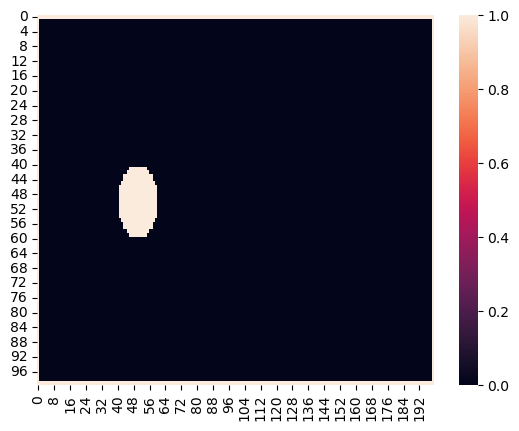

In [6]:
sns.heatmap(geom[:, :, 50].get().T, vmax = 1)

In [10]:
lbm = LBM(geom, 0.50003, 30.0)
lbm.run(num_steps = 600)

u0: 0.09964218457461867
Reynolds Number:  997048.7250636022


  0%|          | 0/600 [00:00<?, ?it/s]

step: 0, rho_min: 0.9999998211860657
step: 500, rho_min: 0.6968128681182861


<Axes: >

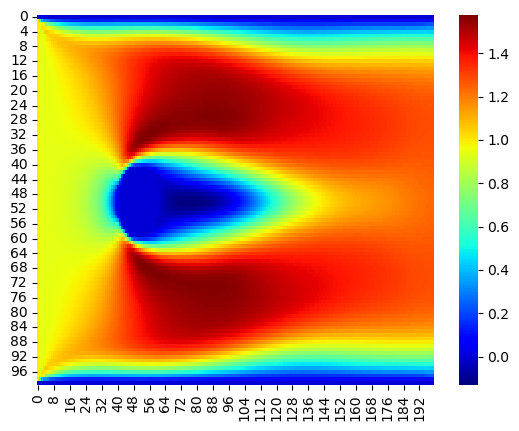

In [66]:
sns.heatmap(lbm.c_u*lbm.ux[:, :, 50].get().T, cmap='jet')